# Run MCMC for JIMWLK

In [4]:
from src import workdir, parse_model_parameter_file
from src.emulator_BAND import EmulatorBAND
from src.mcmc import Chain

import dill
import os
import pickle

In [5]:
exp_path = "./exp_data_JIMWLK.pkl"
model_par = "./IP_DIFF_JIMWLK_prior_range_delete_unused"
mymcmc = Chain(expdata_path=exp_path, model_parafile=model_par)


[INFO][mcmc] Initializing MCMC ...
[INFO][mcmc] Final Markov Chain results will be saved in mcmc/chain.pkl
[INFO][mcmc] Loading the model parameters space from ./IP_DIFF_JIMWLK_prior_range_delete_unused ...
[INFO][mcmc] Run MCMC with emcee...
[INFO][mcmc] Loading the experiment data from ./exp_data_JIMWLK.pkl ...
[INFO][mcmc] Experimental dataset size: 73


In [6]:
emuPathList = ["./emulator.pkl"]
mymcmc.loadEmulator(emuPathList)

[INFO][mcmc] Number of Emulators: 1


In [20]:
os.environ["OMP_NUM_THREADS"] = "1"
# may have to: export RDMAV_FORK_SAFE=1 before running the code
n_effective=800
n_active=400
n_prior=160
sample="tpcn"
n_max_steps=100
random_state=42

n_total = 1000
n_evidence = 1000

pool = 12

sampler = mymcmc.run_pocoMC(n_effective=n_effective, n_active=n_active,
                            n_prior=n_prior, sample=sample,
                            n_max_steps=n_max_steps, random_state=random_state,
                            n_total=n_total, n_evidence=n_evidence, pool=pool)

[INFO][mcmc] Generate the prior class for pocoMC ...
[INFO][mcmc] Starting pocoMC ...


Iter: 17it [01:24,  4.94s/it, beta=1, calls=33400, ESS=958, logZ=-371, logP=-370, acc=0.287, steps=4, eff=1]               

[INFO][mcmc] Generate the posterior samples ...
[INFO][mcmc] Generate the evidence ...
Log evidence:  -370.9141412809986
Log evidence error:  0.286662517651133
[INFO][mcmc] Writing pocoMC chains to file...


In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 15})

In [22]:
PARAMETER_NAMES = [
    r'$m\;[\mathrm{GeV}]$',
    r'$B_G\;[\mathrm{GeV}^{-2}]$',
    r'$B_{G,{\rm q}}\;[\mathrm{GeV}^{-2}]$',
    r'$\sigma$',
    r'$N_{\rm q}$',
    r'$Q_{s}/\mu$',
    r'$m_{\rm JIMWLK}$',
    r'$\Lambda_{\rm QCD}$'
    ]

prior_ranges = [
    (0.05,3),
    (1,10),
    (0.1,3),
    (0,1.5),
    (1,10),
    (0.2,1.5),
    (0.05,3),
    (0.001,0.2)
] 

def read_pkl_file_chain_pocoMC(PATH_pklfile_chains):
    """
    data is a dictionary containing:
    - 'chain'
    - 'weights'
    - 'logl'
    - 'logp'
    - 'logz'
    - 'logz_err'
    """
    with open(PATH_pklfile_chains, 'rb') as pf:
        data = pickle.load(pf)

    return data

In [23]:
def plot_corner_1dataset(n_parameters,data_array,filename,real_parameters=None):
    # check the dimension of the data array
    dim = len(data_array.shape)
    if dim == 3:
        samples = data_array[:,:,:].reshape((-1,n_parameters))
    elif dim == 2:
        samples = data_array[:,:].reshape((-1,n_parameters))
    else:
        raise ValueError("The data array should have 2 or 3 dimensions")

    # Create subplots
    fig, axes = plt.subplots(n_parameters, n_parameters, figsize=(25, 25), sharex='col', sharey='row')

    # Loop over each parameter pair
    for i in range(n_parameters):
        for j in range(n_parameters):
            ax = axes[i, j]

            if i == j:
                ax = fig.add_subplot(n_parameters, n_parameters, i * n_parameters + j + 1)
                ax.hist(samples[:, i], bins=20, color='g', histtype='step', density=True)
                ax.set_yticks([])
                ax.set_yticklabels([])
                if i != n_parameters-1:
                    ax.set_xticks([])
                    ax.set_xticklabels([])
                if i == n_parameters-1:
                    ax.tick_params(axis='x', rotation=45, labelsize=10)

                # Calculate percentiles
                percentiles = np.percentile(samples[:, i], [16, 50, 84])
                median = percentiles[1]
                upper = percentiles[2] - median
                lower = median - percentiles[0]

                ax.annotate(fr'${median:.2f}_{{-{lower:.2f}}}^{{+{upper:.2f}}}$', xy=(0.5, 1.05), xycoords='axes fraction', ha='center')

                # Add a vertical line representing the real value
                if real_parameters is not None:
                    real_value = real_parameters[i]
                    ax.axvline(x=real_value, color='k', linestyle='-')

                ax.set_xlim([prior_ranges[i][0], prior_ranges[i][1]])
            # Only fill the lower triangle
            if i > j:
                ax.hist2d(samples[:, j], samples[:, i], bins=20, cmap='Greens')


            # Set labels on the lowest and leftmost plots
            if i == n_parameters - 1:
                ax.set_xlabel(PARAMETER_NAMES[j])
            if j == 0:
                ax.set_ylabel(PARAMETER_NAMES[i])

            if i < j:
                ax.axis('off')

    # Remove space between subplots
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

    # Remove ticks and labels for the first and last plots
    axes[0, 0].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axes[n_parameters - 1, n_parameters - 1].tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

    # Rotate x-axis tick labels
    for ax in axes[-1]:
        ax.tick_params(axis='x', rotation=45, labelsize=10)

    # Rotate y-axis tick labels
    for ax in axes[:, 0]:
        ax.tick_params(axis='y', rotation=45, labelsize=10)

    plt.savefig(f"{filename}.pdf")

In [24]:
PATH_pklfile = './mcmc/chain.pkl'
RUN1_DATA = read_pkl_file_chain_pocoMC(PATH_pklfile)

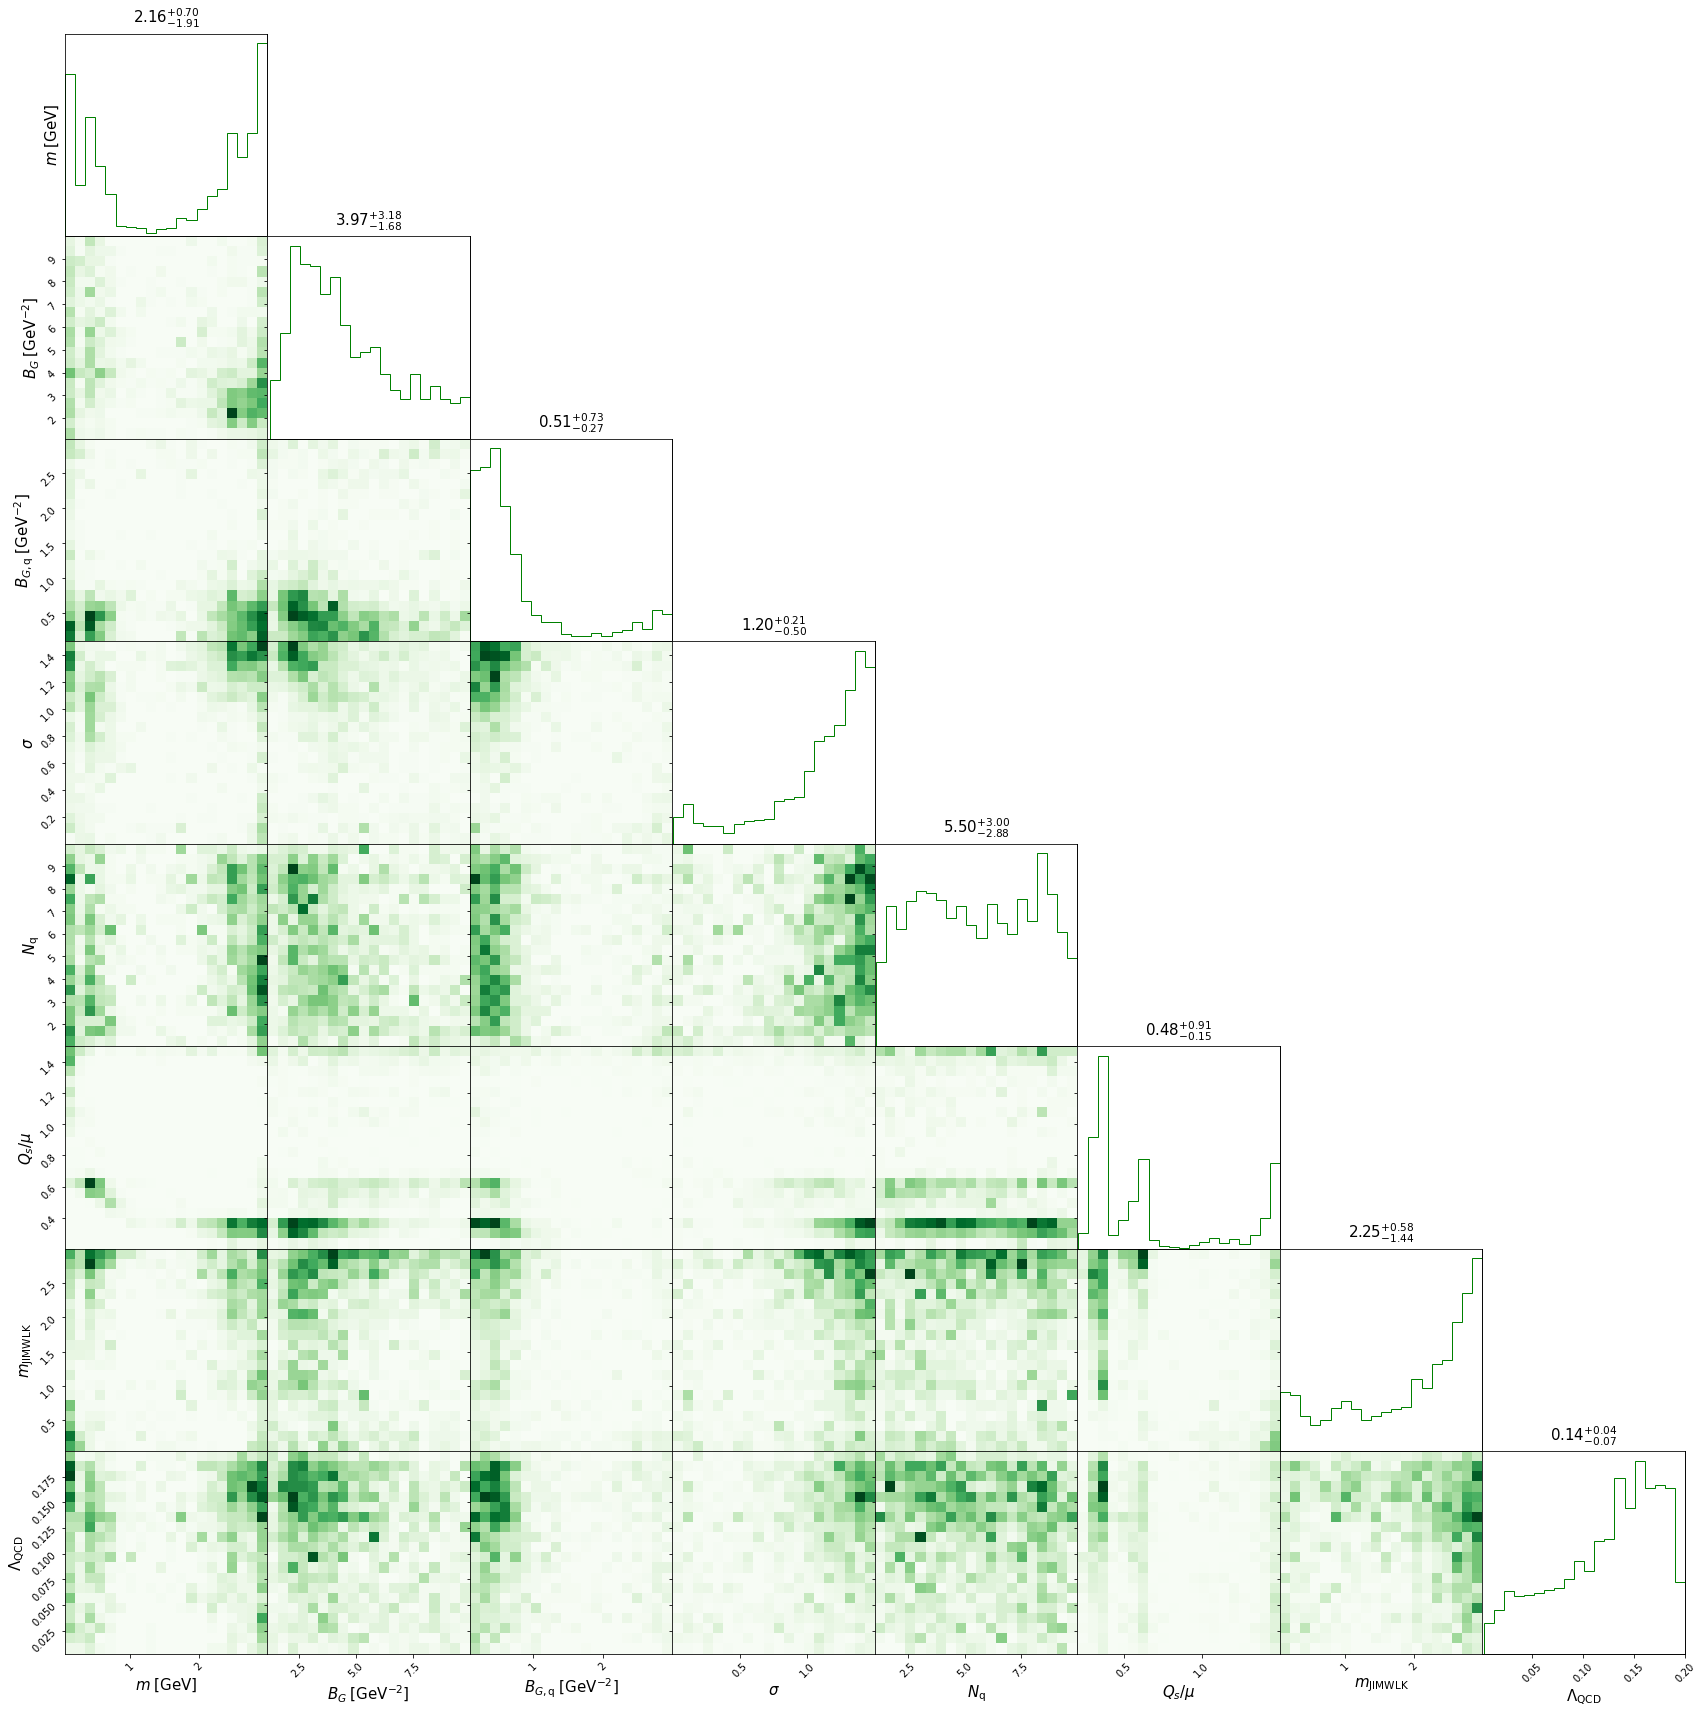

In [25]:
plot_corner_1dataset(8,RUN1_DATA['chain'],'corner_plot',real_parameters=None)

In [26]:
# second method to find the maximum likelihood
from scipy import optimize
from src.mcmc import Chain

bound_min = [a[0] for a in prior_ranges]
bound_max = [b[1] for b in prior_ranges]
bounds = [(a,b) for (a,b) in zip(bound_min,bound_max)]

rslt = optimize.differential_evolution(lambda x: -mymcmc.log_likelihood(x.T), 
                                        bounds=bounds,
                                        maxiter=10000,
                                        disp=True,
                                        tol=1e-9,
                                        vectorized=True,
                                        )
print(rslt.x)

# print the MAP parameters to file
with open('MAP_parameters_JIMWLK.dat','w') as f:
    for i in range(len(rslt.x)):
        f.write(f'{PARAMETER_NAMES[i]}: {rslt.x[i]}\n')

TypeError: differential_evolution() got an unexpected keyword argument 'vectorized'